In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


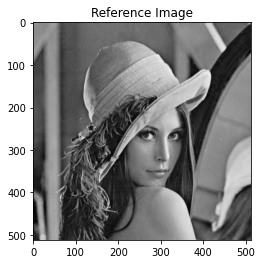

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2 

def RGBtoGRAY(image):
  return np.dot(image[...,:3], [0.3, 0.5, 0.2])


imagec = cv2.imread('/content/drive/MyDrive/Colab Notebooks/lena.bmp')# My reference Image
image=RGBtoGRAY(imagec)
plt.figure()
plt.title('Reference Image')
plt.imshow(image,cmap='gray')

In [ ]:
def gauss_kernel(size, sigma):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    gnormal =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return gnormal


# Defining a filter

def filter(image, kernel):

    # Convolution with vertical mask
    kernel = np.flipud(np.fliplr(kernel))

    x_K = kernel.shape[0] 
    y_K = kernel.shape[1] 
    x_I = image.shape[0] 
    y_I = image.shape[1]
    x_O = int(x_I -x_K  + 1)
    y_O = int(y_I -y_K + 1)
    output = np.zeros((x_O, y_O))
    for i in range(y_O):
        for j in range(x_O):
            output[j][i] = (kernel * image[j: j + x_K, i: i + y_K]).sum()


    return output

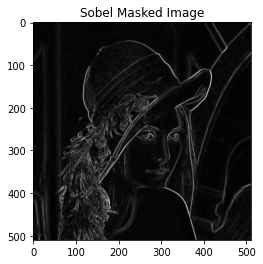

In [ ]:

# Denoising of image using Gaussian blur, as edge detection is sensitive to noise
kernel=gauss_kernel(10,1);
image_g=filter(image,kernel)

# Defining vertical Sobel Mask
kernel_vert = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)

#Defining horizonatal Sobel Mask
kernel_horz = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)


# Applying vertical Sobel Mask
kernel=kernel_vert
new_image_sobel_Y=filter(image,kernel)


# Applying vertical Sobel Mask
kernel=kernel_horz
new_image_sobel_X=filter(image,kernel)

# Gradiant Map
gradient_mag = np.sqrt(np.square(new_image_sobel_X) + np.square(new_image_sobel_Y))
gradient_mag *= 255.0 / gradient_mag.max()
plt.figure()
plt.title('Sobel Masked Image')
plt.imshow(gradient_mag,cmap='gray')

In [ ]:
def line_detection_non_vectorized(image, edge_image, num_rhos=180, num_thetas=180, t_count=220):
  edge_height, edge_width = edge_image.shape[:2]
  edge_height_half, edge_width_half = edge_height / 2, edge_width / 2
  #
  d = np.sqrt(np.square(edge_height) + np.square(edge_width))
  dtheta = 180 / num_thetas
  drho = (2 * d) / num_rhos
  #
  thetas = np.arange(0, 180, step=dtheta)
  rhos = np.arange(-d, d, step=drho)
  #
  cos_thetas = np.cos(np.deg2rad(thetas))
  sin_thetas = np.sin(np.deg2rad(thetas))
  #
  accumulator = np.zeros((len(rhos), len(rhos)))
  
  for y in range(edge_height):
    for x in range(edge_width):
      if edge_image[y][x] != 0:
        edge_point = [y - edge_height_half, x - edge_width_half]
        ys, xs = [], []
        for theta_idx in range(len(thetas)):
          rho = (edge_point[1] * cos_thetas[theta_idx]) + (edge_point[0] * sin_thetas[theta_idx])
          theta = thetas[theta_idx]
          rho_idx = np.argmin(np.abs(rhos - rho))
          accumulator[rho_idx][theta_idx] += 1
          ys.append(rho)
          xs.append(theta)
  return accumulator, rhos, thetas

In [ ]:

accumulator, thetas, rhos = line_detection_non_vectorized(image, gradient_mag)

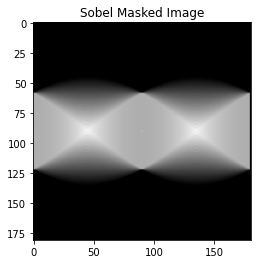

In [ ]:
plt.figure()
plt.title('Sobel Masked Image')
plt.imshow(accumulator,cmap='gray')

In [ ]:
import matplotlib.lines as mlines



t_count=220
edge_height, edge_width = gradient_mag.shape[:2]
edge_height_half, edge_width_half = edge_height / 2, edge_width / 2
# figure = plt.figure(figsize=(12, 12))
# subplot = figure.add_subplot(1, 4, 3)
# subplot1.set_facecolor((0, 0, 0))

Xo=[]
Yo=[]
X1=[]
Y1=[]

for y in range(accumulator.shape[0]):
    for x in range(accumulator.shape[1]):
      if accumulator[y][x] > t_count:
        rho = rhos[y]
        theta = thetas[x]
        a = np.cos(np.deg2rad(theta))
        b = np.sin(np.deg2rad(theta))
        x0 = (a * rho) + edge_width_half
        y0 = (b * rho) + edge_height_half
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

        Xo.append(int(x0))
        Yo.append(int(y0))
        X1.append(int(x1))
        Y1.append(int(y1))
#subplot.imshow(accumulator,cmap='gray')

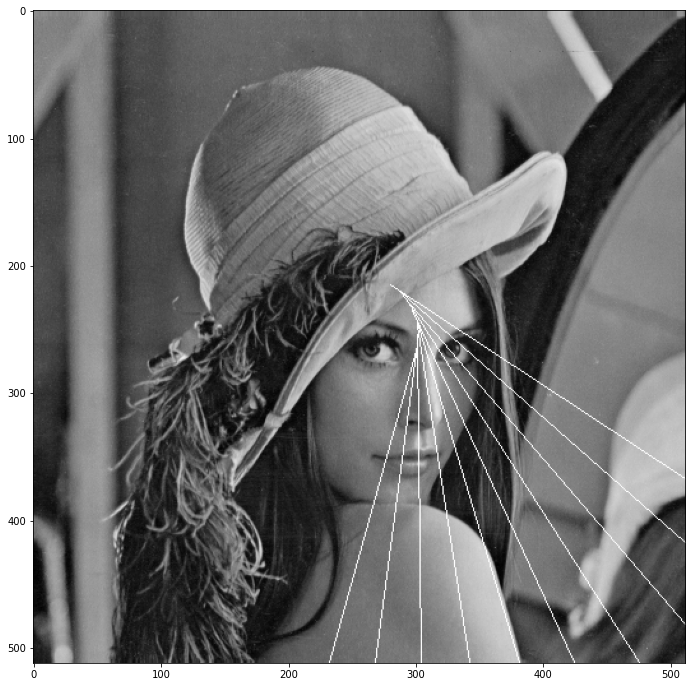

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
for i in range(10):
  plt.imshow(cv2.line(image,(Xo[i],Yo[i]),(X1[i],Y1[i]),(255,0,0),1),cmap='gray') 